In [1]:
# add root dir path of the project
import sys, os
sys.path.append(os.path.abspath(".."))

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# disable warning message
import warnings
warnings.filterwarnings("ignore")

# Load check point
- The model is loaded, trained with pytorch-lightning
- `hparams.yaml` containing definition of the model & dataset is loaded along with model weights

In [4]:
ckpt_dir = "../lightning_logs_tmp/TRAIN/STCNet_8f_CesleaFDD6-1/version_0"
ckpt = os.path.join(ckpt_dir, "checkpoints/epoch=34.ckpt")
hparams_file = os.path.join(ckpt_dir, "hparams.yaml")

In [5]:
# import model
from models.video_classifier import LightningVideoClassifier

# load ckpt
trained_model = LightningVideoClassifier.load_from_checkpoint(ckpt, 
                                                              hparams_file=hparams_file,
                                                              hparam_overrides={"batch_per_gpu": 1})
trained_model.cuda()
trained_model.eval()
# trained_model.freeze()

Using cache found in /root/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


LightningVideoClassifier(
  (model): STC(
    (stc_network): STCNet(
      (layers): ModuleDict(
        (backbone_stem): R2Plus1dStem(
          (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
          (1): BatchNorm3d(45, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
          (4): BatchNorm3d(64, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
        (backbone_layer1): Sequential(
          (0): BasicBlock(
            (conv1): Sequential(
              (0): Conv2Plus1D(
                (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
                (1): BatchNorm3d(144, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
                (2): ReLU(inplace=True)
           

In [6]:
hparams = trained_model.hparams
print(hparams)

Namespace(annotation_file='/data/torch_data/hosp_fall_dataset/fallTrainTestlist', backbone='r2plus1d_34_8_ig65m', batch_per_gpu=1, data_root='/data/torch_data/hosp_fall_dataset/video', dataset='CesleaFDD6', detection_file='/data/torch_data/hosp_fall_dataset/detection_yolo_full.txt', fold=1, freeze_backbone=False, img_height=128, img_width=170, learning_rate=0.0001, mask_supervision=False, mixup=False, model_arch='STCNet', num_workers=16, on_gpu=False, pretrained_path='', sample_duration=8, sample_size=112, squad='2,3,3', stream='rgb', task='classification', weight_decay=0.0001)


# Dataloading stage
Dataloading follows 2-steps
- define transforms(both spatial and temporal)
- get dataloaders
    - (train, val, test)

In [7]:
# import modules
import torch
import torchvision
from datasets.utils import get_classification_dataloaders
from utils.transforms import (
    Compose,
    RandomResizedCrop3D,
    RandomHorizontalFlip3D,
    MultiScaleCornerCrop,
    MultiScaleCornerCrop3D,
    CenterCrop3D,
    ToTensor3D,
    Normalize3D,
    TemporalRandomCrop,
    TemporalSlidingWindow,
    denormalize,
)


In [8]:
# MEAN & STD for kinetics datasets
MEAN = [0.43216, 0.394666, 0.37645]
STD = [0.22803, 0.22145, 0.216989]

In [9]:
# transforms
center_crop = Compose(
    [CenterCrop3D((hparams.sample_size, hparams.sample_size)), ToTensor3D()]
)
spatial_transform = {
    "train": Compose(
        [
            MultiScaleCornerCrop3D(
                transform2D=MultiScaleCornerCrop(
                    scales=[1.0, 0.875, 0.75, 0.66], size=hparams.sample_size
                )
            ),
            RandomHorizontalFlip3D(),
            ToTensor3D(),
        ]
    ),
    # val/test : use torchvision transforms
    "val": center_crop,
    "test": Compose(
        [
            torchvision.transforms.Lambda(
                lambda clips: torch.stack([center_crop(clip) for clip in clips])
            )
        ]
    ),
}

temporal_transform = {
    "train": TemporalRandomCrop(size=hparams.sample_duration),
    "val": None,
    "test": TemporalSlidingWindow(size=hparams.sample_duration),
}

norm_method = Normalize3D(mean=MEAN, std=STD)

In [10]:
# dataloaders
train_dataloader, val_dataloader, test_dataloader = get_classification_dataloaders(
    hparams, spatial_transform, temporal_transform, norm_method
)


Train : 1410, Valid(sub-clips): 2390, Test(video) : 706


# Evaluation stage
- fuck

In [11]:
import numpy as np
import cv2
import tqdm
import pandas as pd

In [12]:
import torch
import numpy as np
from scipy.ndimage import zoom
from IPython.core.debugger import set_trace

def generate_grad_cam(y_c, A_k):
    grad_val = torch.autograd.grad(y_c, A_k, retain_graph=True)[0].data

    # move CUDA tensor to CPU
    A_k = A_k.cpu()
    grad_val = grad_val.cpu()

    # remove batch dim
    conv_out = A_k.data[0].numpy()
    grad_val = grad_val[0].numpy()

    weights = np.mean(grad_val, axis=(1, 2, 3))

    grad_cam = np.zeros(dtype=np.float32, shape=conv_out.shape[1:])
    for k, w in enumerate(weights):
        grad_cam += w * conv_out[k]

    # upsample grad_cam
    temporal_ratio = 8 / grad_cam.shape[0]
    spatial_ratio = 112 / grad_cam.shape[1]

    grad_cam = zoom(grad_cam, (temporal_ratio, spatial_ratio, spatial_ratio))

    grad_cam = np.maximum(grad_cam, 0)
    grad_cam = grad_cam / (grad_cam.max((1, 2))+1e-6)[:, None, None]

    return grad_cam

In [14]:
class ActivityDetectionTool():
    __classes = ['background', 
                 'falling', 
                 'sitting', 
                 'sleeping', 
                 'standing',
                 'walking']
    
    def __init__(self, model, test_dataloader=None, sample_duration=8):
        """
            Simple Activity Detection tool operating in sliding-window fashion
        """
        if isinstance(model, LightningVideoClassifier):
            model = model.model
        else:
            # ordinary pytorch model?
            pass
            
        self.model = model
        self.test_dataloader = test_dataloader
        self.sample_duration = sample_duration
        self.test_logs = []
        
        if test_dataloader is not None:
            test_samples = np.array(test_dataloader.dataset.samples)[:, 0].ravel()
            test_video_list = test_samples[np.array(test_dataloader.dataset.indices)]
            self.test_video_list = np.array([ name.split(hparams.data_root)[1].strip('/') for name in test_video_list ])

    def predict_single_clip(self, clip, mask):
        if torch.cuda.is_available():
            # load vars on GPU
            clip = clip.cuda()
            mask = mask.cuda()

        # inferenece test code...
        clip_out, feats_dict = self.model(clip, mask)
        clip_feats = feats_dict["STC_c"]
        # numpy array
        clip_logits = torch.softmax(clip_out, 1).detach().cpu().numpy().reshape(-1)
        
        # feature(Grad-CAM) extraction
        grad_cams = []
        for c_ix in range(len(self.classes)):
            grad_cams.append(generate_grad_cam(clip_out[0, c_ix], clip_feats))
            
        grad_cams = np.array(grad_cams)
    
        return clip_logits, grad_cams
    
    def get_sliding_window_results(self, clips, masks):
        frame_level_logits = []
        spatial_heatmaps = []
        for n in range(clips.size(1)):
            subclip = clips[:, n] # (b,c,d,h,w)
            submask = masks[:, n] # (b,c,d,h,w)
            
            # inferenece test code...
            clip_logits, grad_cams = self.predict_single_clip(
                subclip,
                submask
            )
            frame_level_logits += [clip_logits] * self.sample_duration
            spatial_heatmaps.append(grad_cams)
        
        # stack logits
        frame_level_logits = np.array(frame_level_logits)
                
        # stack heatmaps
        spatial_heatmaps = np.array(spatial_heatmaps)
            
        return frame_level_logits, spatial_heatmaps
        
    def log_results(self, test_batch, video_name_):
        if len(test_batch) > 2:
            clips, masks, *_= test_batch  # -> evaluation phase
        elif len(test_batch) == 2:
            clips, masks = test_batch     # -> demo(i.e., label is not available) phase
        else:
            raise ValueError("Invalid test batch configuration, test_batch needs at least 2 modalities(rgb, mask)")
            
        assert clips.dim() == 6, "clips should be stacked along with clip-indices"
        
        frame_level_logits, *_ = self.get_sliding_window_results(clips, masks)

        test_ids = np.array([ 
            os.path.join(video_name_.replace(".avi", ""), f"thumb{j:04d}.txt") for j in range(len(frame_level_logits))
        ])
        test_ids = test_ids[:len(frame_level_logits)]

        row = np.column_stack((test_ids, frame_level_logits))
        self.test_logs += row.tolist()
    
    def evaluate(self):
        if getattr(self, "test_dataloader") is None:
            raise ValueError("To run evaluate(), attribute `test_dataloader` must be given")
            
        for ix, test_batch in enumerate(tqdm.tqdm(self.test_dataloader)):
            video_name_ = self.test_video_list[ix]
            self.log_results(test_batch, video_name_)
            if ix == 100:
                break
    
    def get_results(self):
        test_results = pd.DataFrame(np.array(self.test_logs), columns=['frame_id', *self.__classes])
        test_results.set_index("frame_id", inplace=True)
        return test_results
    
    @property
    def classes(self):
        return self.__classes

adt = ActivityDetectionTool(trained_model, test_dataloader, sample_duration=hparams.sample_duration)
adt.evaluate()
test_results = adt.get_results()

 14%|█▍        | 100/706 [02:12<13:21,  1.32s/it]


# Frame-level Detection Label File
- Assign corresponding activity labels only for frames detected as a person
- If none-of-human is detected(i.e. fall-back label 999999? or something), gives `background` label for that frame

In [15]:
# import modules
import numpy as np
import pandas as pd
import os

In [16]:
# load detection file
detection_file = pd.read_csv(
            hparams.detection_file,
            sep=" ",
            names=["object_class", "x_center", "y_center", "width", "height"],
        )
detection_file.head()

,object_class,x_center,y_center,width,height
background/2020-11-04_10:24:57.379/thumb0000.txt,999999,0.0,0.0,0.0,0.0
background/2020-11-04_10:24:57.379/thumb0001.txt,999999,0.0,0.0,0.0,0.0
background/2020-11-04_10:24:57.379/thumb0002.txt,999999,0.0,0.0,0.0,0.0
background/2020-11-04_10:24:57.379/thumb0003.txt,999999,0.0,0.0,0.0,0.0
background/2020-11-04_10:24:57.379/thumb0004.txt,999999,0.0,0.0,0.0,0.0


In [17]:
detection_file.reset_index(inplace=True)
new_columns = detection_file.columns.values
new_columns[0] = "frame_id"
detection_file.columns = new_columns
detection_file.head()

,frame_id,object_class,x_center,y_center,width,height
0,background/2020-11-04_10:24:57.379/thumb0000.txt,999999,0.0,0.0,0.0,0.0
1,background/2020-11-04_10:24:57.379/thumb0001.txt,999999,0.0,0.0,0.0,0.0
2,background/2020-11-04_10:24:57.379/thumb0002.txt,999999,0.0,0.0,0.0,0.0
3,background/2020-11-04_10:24:57.379/thumb0003.txt,999999,0.0,0.0,0.0,0.0
4,background/2020-11-04_10:24:57.379/thumb0004.txt,999999,0.0,0.0,0.0,0.0


In [18]:
detection_file.loc[detection_file["object_class"] == 0, "y_true"] = detection_file["frame_id"].str.split("/").str[0]
detection_file.loc[detection_file["object_class"] > 0 & (detection_file["y_true"] != "sleeping"), "y_true"] = "background"
detection_file.set_index("frame_id", inplace=True)
detection_file.head()

,object_class,x_center,y_center,width,height,y_true
frame_id,,,,,,
background/2020-11-04_10:24:57.379/thumb0000.txt,999999,0.0,0.0,0.0,0.0,background
background/2020-11-04_10:24:57.379/thumb0001.txt,999999,0.0,0.0,0.0,0.0,background
background/2020-11-04_10:24:57.379/thumb0002.txt,999999,0.0,0.0,0.0,0.0,background
background/2020-11-04_10:24:57.379/thumb0003.txt,999999,0.0,0.0,0.0,0.0,background
background/2020-11-04_10:24:57.379/thumb0004.txt,999999,0.0,0.0,0.0,0.0,background


In [19]:
import collections

print("### Statistics of dataset ###")
print()

for lab in detection_file.y_true.unique():
    det = detection_file[detection_file.y_true==lab]
    frames_per_video = collections.Counter((pd.Series(det.index).str.split("/").str[:2].apply(lambda x: os.path.join(*x))))
    print("-", lab)
    print("  * n_clips : ", len(os.listdir(os.path.join(hparams.data_root, lab))))
    print("  * total_frames :", sum(frames_per_video.values()))
    print("  * avg_frames : ", sum(frames_per_video.values())/len(frames_per_video))
    print()

### Statistics of dataset ###

- background
  * n_clips :  468
  * total_frames : 23378
  * avg_frames :  15.5026525198939

- falling
  * n_clips :  332
  * total_frames : 7534
  * avg_frames :  22.69277108433735

- sitting
  * n_clips :  328
  * total_frames : 7138
  * avg_frames :  21.76219512195122

- sleeping
  * n_clips :  336
  * total_frames : 6718
  * avg_frames :  21.81168831168831

- standing
  * n_clips :  320
  * total_frames : 7622
  * avg_frames :  23.81875

- walking
  * n_clips :  332
  * total_frames : 12156
  * avg_frames :  36.6144578313253



In [20]:
detection_file[detection_file.index.str.startswith("falling/2020-10-15_09:38:58.264")]

,object_class,x_center,y_center,width,height,y_true
frame_id,,,,,,
falling/2020-10-15_09:38:58.264/thumb0000.txt,0,0.507998,0.707978,0.336414,0.560616,falling
falling/2020-10-15_09:38:58.264/thumb0001.txt,0,0.507939,0.713110,0.335595,0.556412,falling
falling/2020-10-15_09:38:58.264/thumb0002.txt,0,0.509813,0.710081,0.335858,0.567379,falling
falling/2020-10-15_09:38:58.264/thumb0003.txt,0,0.509688,0.712030,0.345866,0.564614,falling
falling/2020-10-15_09:38:58.264/thumb0004.txt,0,0.509255,0.710859,0.349711,0.565712,falling
...,...,...,...,...,...,...
falling/2020-10-15_09:38:58.264_flip/thumb0030.txt,0,0.763320,0.773632,0.201340,0.438216,falling
falling/2020-10-15_09:38:58.264_flip/thumb0031.txt,0,0.760134,0.790709,0.232692,0.434035,falling
falling/2020-10-15_09:38:58.264_flip/thumb0032.txt,0,0.760451,0.792692,0.233838,0.431109,falling


# Evaluate
- MAP(Mean Average Precision) is used

$$ \text{MAP} = {1 \over \ C} \sum_c \sum_n (R_{n,c} - R_{n-1,c}) P_{n,c}$$


In [21]:
from sklearn.metrics import average_precision_score

In [22]:
y_pred = test_results
y_true = detection_file[["y_true"]]

print("### Frame-level precision report ####")
print()

mean_ap = []
for c in adt.classes:
    y_pred_c = y_pred[c]
    y_true_c = (y_true[y_true.y_true==c]==c).astype(int) # binary labels
    
    report = pd.merge(y_pred_c, y_true_c, on="frame_id", how="inner")
    if len(report):
        ap = average_precision_score(report.y_true, report[c].values.astype(float))
        print("-", c)
        print("  * length of frames under evaluation :", len(report))
        print(f"  * AP={ap:.4f}")
        print()
        
        mean_ap.append(ap)

print(f"@ MAP={np.mean(mean_ap):.4f}")

### Frame-level precision report ####

- background
  * length of frames under evaluation : 2424
  * AP=1.0000

@ MAP=1.0000


# Predict

In [23]:
import random
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
test_samples = np.array(test_dataloader.dataset.samples)[:, 0].ravel() 
test_video_list = test_samples[np.array(test_dataloader.dataset.indices)]
test_video_list = [ (name, cv2.VideoCapture(name).get(cv2.CAP_PROP_FRAME_COUNT)) for name in test_video_list ]
test_video_list = np.array([ (name.split(hparams.data_root)[1].strip('/'), int(cnt)) for name, cnt in test_video_list ])

In [30]:
def video_id(p):
    return os.path.splitext(p[len(hparams.data_root):])[0].strip('/')

In [ ]:

video_path = os.path.join(hparams.data_root, test_video_list[:, 0][random.randint(0, len(test_video_list)+1)])
# video_path = '/data/torch_data/hosp_fall_dataset/video/sitting/2020-10-23_11:36:41.957_flip.avi'
# video_path = "/data/torch_data/hosp_fall_dataset/video/sleeping/2020-10-19_11:07:34.673.avi"
# video_path = "/data/torch_data/hosp_fall_dataset/video/falling/2020-10-23_11:33:48.328.avi"

print("predicting", video_path)
print()

# set position at middle
cap = cv2.VideoCapture(video_path)
video_duration_ms = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS) * 1000
    
fig = plt.figure(figsize=(20,7))
for i,pos in enumerate(np.linspace(0.2, 1, num=8, endpoint=False)):
    ax = fig.add_subplot(1,8,i+1)
    cap.set(cv2.CAP_PROP_POS_MSEC, video_duration_ms * pos)
    # show frame
    _, frame = cap.read()
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig("example.png", dpi=300)

res = y_pred[y_pred.index.str.startswith(video_id(video_path))].astype(float)
averaged_res = res.mean()
final_res = averaged_res.argmax()


plt.figure(figsize=(20,7))
ax = sns.lineplot(data=res)
ax.set_xticks([])
ax.set_xlabel("time")
ax.set_ylabel("prediction")
# ax.set_ylim([0.0, 0.1])
plt.savefig("life_log_demo.png", dpi=300)

print("### Time-averaged Results ###")
print(averaged_res)
print()

print("### Final prediction ###")
print(final_res)
print()

# Activity detection for a given video file

To run activity detection, 3 steps should be done before inference
- Read video file
- Genreate mask frames from detection file
- Compose sliding windows and stack clips

In [25]:
import torch
import torchvision
from utils.transforms import Resize3D
from datasets.classification._utils import generate_maskImg
import pandas as pd

In [306]:
video_path = "/data/torch_data/hosp_fall_dataset/video/sitting/2020-10-15_16:08:57.401_flip.avi"

# read video file

In [307]:
video, audio, info = torchvision.io.read_video(video_path)
video = video.permute(0, 3, 1, 2).float()
video = (video - video.min()) / (video.max() - video.min())
video = Resize3D(size=(hparams.img_height, hparams.img_width), keep_ratio=False)(video)

# load detection file for demo

In [308]:
detection_file = pd.read_csv(
            hparams.detection_file,
            sep=" ",
            names=["object_class", "x_center", "y_center", "width", "height"],
        )
del detection_file["object_class"]
detection_file.head(2)

,x_center,y_center,width,height
background/2020-11-04_10:24:57.379/thumb0000.txt,0.0,0.0,0.0,0.0
background/2020-11-04_10:24:57.379/thumb0001.txt,0.0,0.0,0.0,0.0


# generate mask frames


In [309]:
query = detection_file.index[detection_file.index.str.startswith(video_id(video_path))]

mask_images = []
for q in query:
    m = generate_maskImg(detection_file, q, W=hparams.img_width, H=hparams.img_height)
    mask_images.append(m)

In [310]:
m.shape

torch.Size([3, 128, 170])

# stack clips(both video-clips and masks)


In [311]:
# convert to tensor for smart indexing
video = torch.stack(video)
mask = torch.stack(mask_images)

# clip_pts = torch.as_tensor(LoopPadding(size=self.duration)(clip_pts.tolist()))
multi_clip_pts = temporal_transform["test"](list(range(len(video))))
clips = []
masks = []
for sample_pts in multi_clip_pts:
    # convert List -> Tensor
    sample_pts = torch.as_tensor(sample_pts)
    clips.append(video[sample_pts])  # (D,C,H,W)
    masks.append(mask[sample_pts])  # (D,1,H,W)

clips = torch.stack(clips)  # (nclips,D,C,H,W)
masks = torch.stack(masks)  # (nclips,D,1,H,W)

In [312]:
# apply spatial transform for test
clips = spatial_transform["test"](clips)
masks = spatial_transform["test"](masks)

In [313]:
# normalization & configuration of axis order
permute_axis = (0, 4, 1, 2, 3)
clips = norm_method(clips).permute(*permute_axis)  # apply norm method
masks = masks[..., :1].permute(*permute_axis)

In [314]:
# expand batch dimension
clips = clips[None, ...]
masks = masks[None, ...]

In [315]:
adt = ActivityDetectionTool(trained_model, sample_duration=hparams.sample_duration)
adt_results, spatial_heatmaps = adt.get_sliding_window_results(clips, masks)

In [316]:
print(clips.shape)
print(spatial_heatmaps.shape)

torch.Size([1, 5, 3, 8, 112, 112])
(5, 6, 8, 112, 112)


In [317]:
from utils.transforms import denormalize
from torchvision.utils import make_grid
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
%matplotlib inline

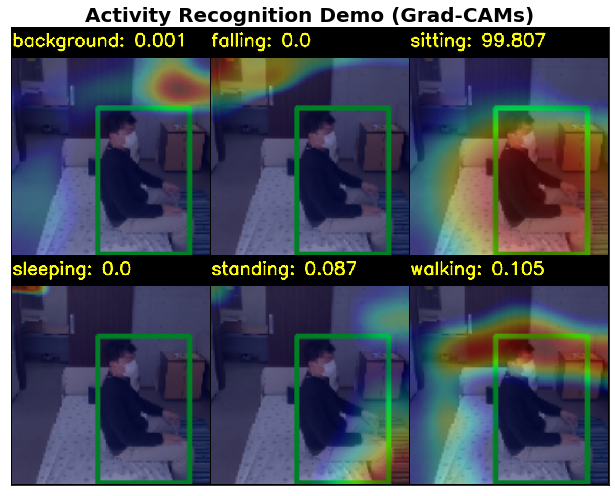

In [318]:
class ActivityDetection_Visualization():
    def __init__(self, clips, masks, spatial_heatmaps, scores, classes):
        self.ims = []
        self.fig = plt.figure(figsize=(10,7))
        for clip_ix in range(len(clips)):
            self.draw_results(clips[clip_ix], masks[clip_ix], spatial_heatmaps[clip_ix], scores[clip_ix], classes)
        plt.title("Activity Recognition Demo (Grad-CAMs)", fontdict={"fontsize": 20, "fontweight": "bold"})
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        
    def get_bbox_from_mask(self, mask):
        pos = torch.where(mask)
        
        xmin = torch.min(pos[-1]).item()
        xmax = torch.max(pos[-1]).item()
        ymin = torch.min(pos[-2]).item()
        ymax = torch.max(pos[-2]).item()
        return (xmin,ymin), (xmax,ymax)
    
    def get_dist_of_logits(self, scores, classes):
        # Barplot
        fig, ax = plt.subplots()

        ax.bar(range(len(scores)), scores)
        ax.set_xticks(range(len(scores)))
        ax.set_xticklabels(classes, rotation=45)
        ax.get_xticklabels()[scores.argmax()+1].set_color("red")
        logit_dist = figure_to_array(fig)
        plt.close(fig)

        return logit_dist

    def draw_results(self, clip, mask, heatmap, scores, classes):
        for t in range(clip.size(1)):
            clip_ = clip[:,t].permute(1,2,0)
            img_ = np.uint8(255*denormalize(clip_, MEAN, STD))
            
            bbox = None
            if mask[:, t].eq(1).any() == True:
                bbox = self.get_bbox_from_mask(mask[:, t])
                img_ = cv2.rectangle(img_, bbox[0], bbox[1], (0,255,0), 2)

            cam_grid = []
            for i, c_ix in enumerate(range(len(classes))):
                heatmap_ = np.uint8(255*heatmap[c_ix][t])
                heatmap_ = cv2.applyColorMap(heatmap_, cv2.COLORMAP_JET)
                heatmap_ = cv2.cvtColor(heatmap_, cv2.COLOR_BGR2RGB)
                frame = np.uint8(heatmap_*0.3 + img_*0.5)
                frame = cv2.resize(frame, (336,336))
                w,c = frame.shape[1:]
                frame = np.row_stack((np.zeros((50, w,c), dtype="uint8"), frame))
                frame = cv2.putText(frame, classes[c_ix] + ': '+str(np.round(scores[c_ix]*100,3)), (0,30), 
                                    cv2.FONT_ITALIC, 1.0, (255, 255, 0), 2, cv2.LINE_AA)
                cam_grid.append(frame)
            
            # CAM display part
            cam_grid = torch.from_numpy(np.array(cam_grid))
            cam_grid = make_grid(cam_grid.permute(0,3,1,2), nrow=3)
            cam_grid = cam_grid.permute(1,2,0).numpy()
            im = plt.imshow(cam_grid, animated=True)
            self.ims.append([im])
        
    def save_result(self):
        ani = animation.ArtistAnimation(self.fig, self.ims, interval=100, blit=True,
                                        repeat_delay=1000)
        return HTML(ani.to_html5_video())
    
scores = [x[0] for x in np.split(adt_results, hparams.sample_duration)] 
adtVis= ActivityDetection_Visualization(clips[0], masks[0], spatial_heatmaps, scores, adt.classes)
adtVis.save_result()